In [1]:
import os
from src import *
from typing import List, Dict
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

"""
COMPAS:
Caucasian  count: 2454
Other  count: 377
Hispanic  count: 637
African-American  count: 3696

ADULT:
Amer-Indian-Eskimo  count: 311
White  count: 27816
Asian-Pac-Islander  count: 1039
Black  count: 3124
Other  count: 271
""" 

other = {Tester.OPT_ALL_RACE_SPLITS: True}
Tester.VERBOSE = False
other_fb = other.copy()
other_fb[BaseModel.OPT_FBALANCE] = True
all_metrics = Metrics.get_all_names()

datasets =  [Tester.COMPAS_D, Tester.ADULT_D]
mls_basic = { # bias mitigation method, ML algo, secondary ML alg, preprocessing, other
    "FB Baseline":(Tester.BASE_ML,      Model.LG_R, None, "FairBalance", other_fb), 
    "FairBalance":(Tester.FAIRBALANCE,  Model.LG_R, None, "FairBalance", other_fb), 

    "FM Baseline":(Tester.BASE_ML,      Model.RF_C, None,       None,    other), 
    "FairMask":   (Tester.FAIRMASK,     Model.RF_C, Model.DT_R, None,    other)
}


## ALL METRICS TABLE

In [2]:
# 1 file each for compas and adult tables. 
# func input: dataset, reps, metrics?, filename

def all_race_splits(dataset, reps, filename, metrics = all_metrics, clear_file = True, attrs = None):
    file = os.path.join("results",filename +".csv")
    if clear_file: os.remove(file)
    
    tester = Tester(file)
    for bias_mit, method, method2, pre, oth in list(mls_basic.values()):
        tester.run_test(metrics, dataset, bias_mit, method, method2, reps, same_data_split=(reps==1), data_preprocessing=pre, other = oth, sensitive_attr=attrs)

In [3]:
# call both
repetitions = 1
# bias mitigated agaist sex and race
##all_race_splits(Tester.COMPAS_D, repetitions, "CompasTESTING")
##all_race_splits(Tester.ADULT_D,  repetitions, "AdultTESTING")
# bias mitigation agaist only race
##all_race_splits(Tester.COMPAS_D, repetitions, "CompasTESTING", ["race"])
##all_race_splits(Tester.ADULT_D,  repetitions, "AdultTESTING", ["race"])

## METRIC GRAPHS

In [4]:

def make_graph(plt,baselines: List[float], results: Dict[str,List[float]], labels: List[str]):
    x_pos = np.arange(len(labels))
    plt.bar(x_pos, baselines, align='center', alpha=0.5, label = "baseline")
    #plt.xticks(y_pos, labels)
    plt.set(xticks=x_pos, xticklabels=labels)

    for k, v in results.items():
        plt.plot(v, linestyle='--', marker='o', label="bias mit towards "+k)

    plt.legend()
    return plt


In [5]:

def graph_all_race_splits(plt,dataset, baseline, mitigation, metric, title, reps, attrs):
    tester = Tester(os.path.join("results","history" +".csv"))
    
    bias_mit, method, method2, pre, oth = baseline
    tester.run_test(all_metrics, dataset, bias_mit, method, method2, reps, same_data_split=(reps==1), data_preprocessing=pre, other = oth, sensitive_attr=attrs)
    baseline_results = tester.get_eval_for_each_race_split(metric)
    races = list(baseline_results.keys())

    #results = {key:list(baseline_results.values()) for key in races}
    results = {key:[] for key in races}
    bias_mit, method, method2, pre, oth = mitigation
    for race in races:
        tester.update_training_race_split(race)
        tester.run_test(all_metrics, dataset, bias_mit, method, method2, reps, same_data_split=(reps==1), data_preprocessing=pre, other = oth, sensitive_attr=attrs)
        results[race] = list(tester.get_eval_for_each_race_split(metric).values())

    make_graph(plt,list(baseline_results.values()), results, races)

    plt.set_ylabel(metric)
    plt.set_title(title)
    plt.autoscale(enable=True) 
    return plt


In [6]:


def run_experiment_group(reps, metric, mls = mls_basic, attrs = None):
    fig, axes = plt.subplots(nrows=1, ncols=4)
    fig.tight_layout()
    fig.set_size_inches(25, 7, forward=True)
    ax1, ax2, ax3, ax4 = axes.flatten()

    graph_all_race_splits(ax1,Tester.COMPAS_D, mls["FM Baseline"], mls["FairMask"],    metric, "FairMask effect on COMPAS", reps, attrs)
    graph_all_race_splits(ax2,Tester.COMPAS_D, mls["FB Baseline"], mls["FairBalance"], metric, "FairBalance effect on COMPAS", reps, attrs)
    graph_all_race_splits(ax3,Tester.ADULT_D,  mls["FM Baseline"], mls["FairMask"],    metric, "FairMask effect on Adult", reps, attrs)
    graph_all_race_splits(ax4,Tester.ADULT_D,  mls["FB Baseline"], mls["FairBalance"], metric, "FairBalance effect on Adult", reps, attrs)

    plt.show()

def run_fb_experiment_group(reps, metric, mls = mls_basic, attrs = None):
    fig, axes = plt.subplots(nrows=1, ncols=2)
    fig.tight_layout()
    fig.set_size_inches(14, 7, forward=True)
    ax1, ax2 = axes.flatten()

    graph_all_race_splits(ax1,Tester.COMPAS_D, mls["FB Baseline"], mls["FairBalance"], metric, "FairBalance effect on COMPAS", reps, attrs)
    graph_all_race_splits(ax2,Tester.ADULT_D,  mls["FB Baseline"], mls["FairBalance"], metric, "FairBalance effect on Adult", reps, attrs)

    plt.show()


## GRAPH CHANGE IN METRIC

In [7]:
def make_change_graph(plt, changes, races): 
    x_pos = np.arange(len(races))
    colors = cm.rainbow(np.linspace(0, 1, len(races)+1))
    plt.set(xticks=x_pos, xticklabels=races)

    for i in range(len(races)):
        race_changes = np.array(changes[races[i]])
        avg = np.mean(race_changes, axis=0)
        plt.plot(avg,linestyle='--', marker='o', color= colors[i], label="bias mit towards "+races[i])

        for exp in race_changes:
            plt.scatter(x_pos, exp, marker='o', color= colors[i])

    plt.plot(np.zeros_like(avg), color= 'k')
    plt.plot(np.zeros_like(avg)-1, color= '0.6')
    plt.plot(np.zeros_like(avg)+1, color= '0.6')

    plt.legend()
    return plt

In [8]:
def graph_all_metric_changes(plt,dataset, baseline, mitigation, metric, title, reps, attrs):
    changes = None
    for r in range(reps):   
        tester = Tester(os.path.join("results","change_history" +".csv")) 
        
        bias_mit, method, method2, pre, oth = baseline
        tester.run_test(all_metrics, dataset, bias_mit, method, method2, reps, same_data_split=True, data_preprocessing=pre, other = oth, sensitive_attr=attrs)
        baseline_results = tester.get_eval_for_each_race_split(metric)
        baseline_vals = np.array(list(baseline_results.values()))
        races = list(baseline_results.keys())
        if not changes:
            changes = {race:[] for race in races}

        bias_mit, method, method2, pre, oth = mitigation
        for race in races:
            tester.update_training_race_split(race)
            tester.run_test(all_metrics, dataset, bias_mit, method, method2, reps, same_data_split=True, data_preprocessing=pre, other = oth, sensitive_attr=attrs)
            results = np.array(list(tester.get_eval_for_each_race_split(metric).values()))
            changes[race].append(np.abs(baseline_vals) * results / (baseline_vals*baseline_vals))     

    make_change_graph(plt, changes, races)

    plt.set_ylabel(metric)
    plt.set_title(title)
    plt.autoscale(enable=True) 
    return plt

In [9]:

def run_change_experiment_group(reps, metric, mls = mls_basic, attrs = None):
    fig, axes = plt.subplots(nrows=1, ncols=4)
    fig.tight_layout()
    fig.set_size_inches(25, 7, forward=True)
    ax1, ax2, ax3, ax4 = axes.flatten()

    graph_all_metric_changes(ax1,Tester.COMPAS_D, mls["FM Baseline"], mls["FairMask"],    metric, "FairMask effect on COMPAS", reps, attrs)
    graph_all_metric_changes(ax2,Tester.COMPAS_D, mls["FB Baseline"], mls["FairBalance"], metric, "FairBalance effect on COMPAS", reps, attrs)
    graph_all_metric_changes(ax3,Tester.ADULT_D,  mls["FM Baseline"], mls["FairMask"],    metric, "FairMask effect on Adult", reps, attrs)
    graph_all_metric_changes(ax4,Tester.ADULT_D,  mls["FB Baseline"], mls["FairBalance"], metric, "FairBalance effect on Adult", reps, attrs)

    plt.show()

def run_change_fb_experiment_group(reps, metric, mls = mls_basic, attrs = None):
    fig, axes = plt.subplots(nrows=1, ncols=2)
    fig.tight_layout()
    fig.set_size_inches(14, 7, forward=True)
    ax1, ax2 = axes.flatten()

    graph_all_metric_changes(ax1,Tester.COMPAS_D, mls["FB Baseline"], mls["FairBalance"], metric, "FairBalance effect on COMPAS", reps, attrs)
    graph_all_metric_changes(ax2,Tester.ADULT_D,  mls["FB Baseline"], mls["FairBalance"], metric, "FairBalance effect on Adult", reps, attrs)

    plt.show()

## RUNNING EXPERIMENTS

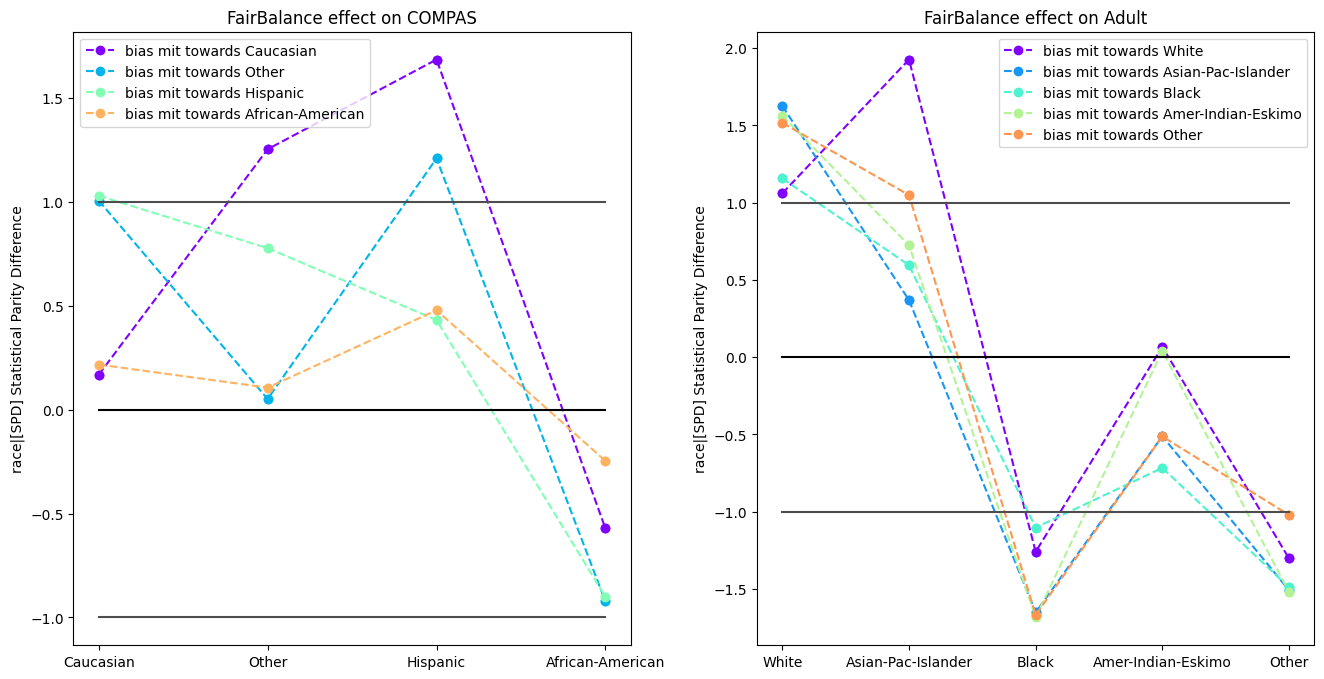

In [11]:
# Change in bias scale. (change in the absolute value of spd) 
reps = 20
metric = 'race|'+Metrics.SPD
run_change_experiment_group(reps, metric, attrs = ["race"])
# same but bias mitigated for sex and race
run_change_experiment_group(reps, metric)

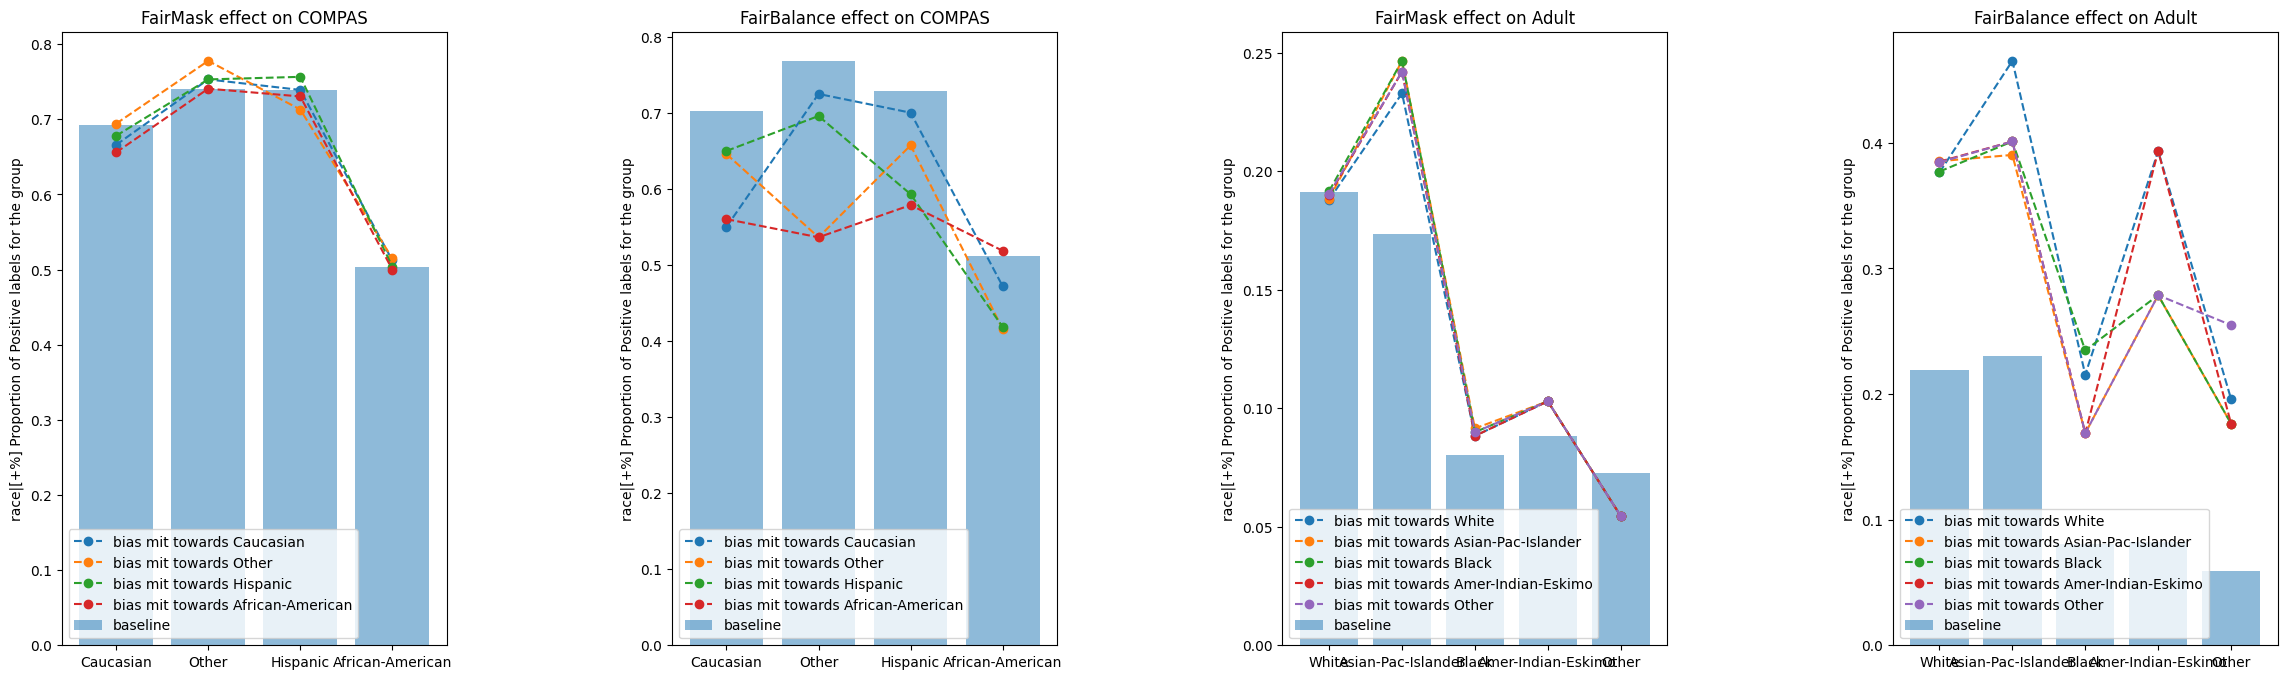

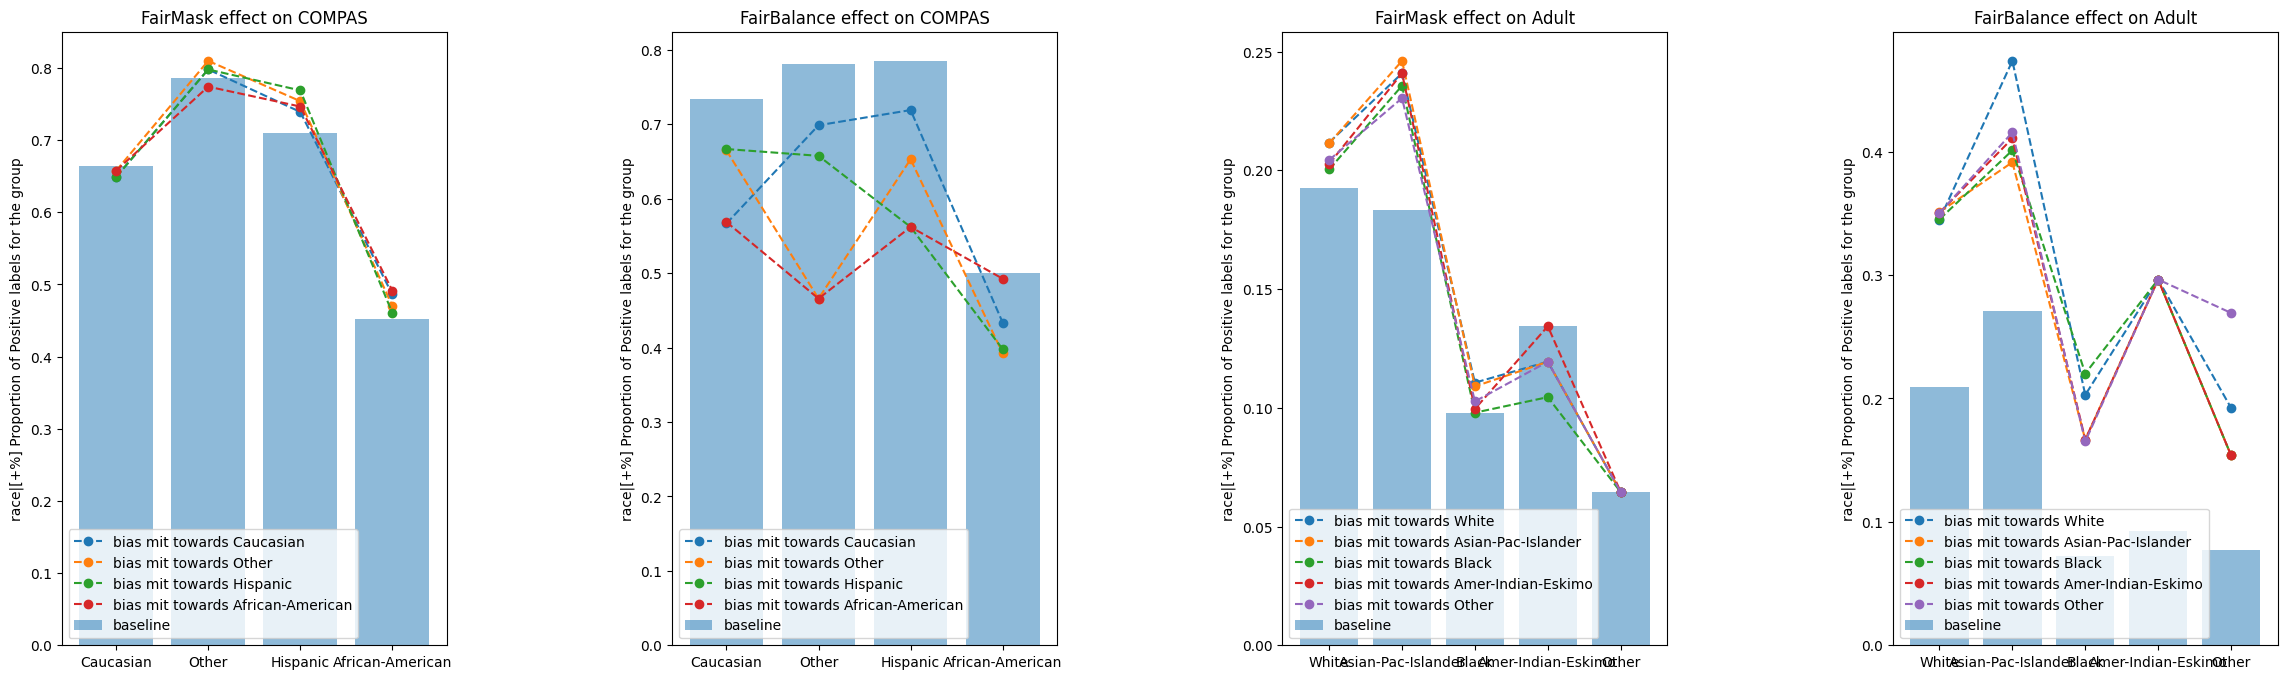

In [13]:
# proportion of positive lables for each race for one run
reps = 1
metric = 'race|'+Metrics.POS
run_experiment_group(reps, metric, attrs =  ["race"])
# same but bias mitigated for sex and race
run_experiment_group(reps, metric)


 new tester ---------------------------------
--------------
--------------
--------------
--------------
--------------

 new tester ---------------------------------
--------------
--------------
--------------
--------------
--------------
--------------


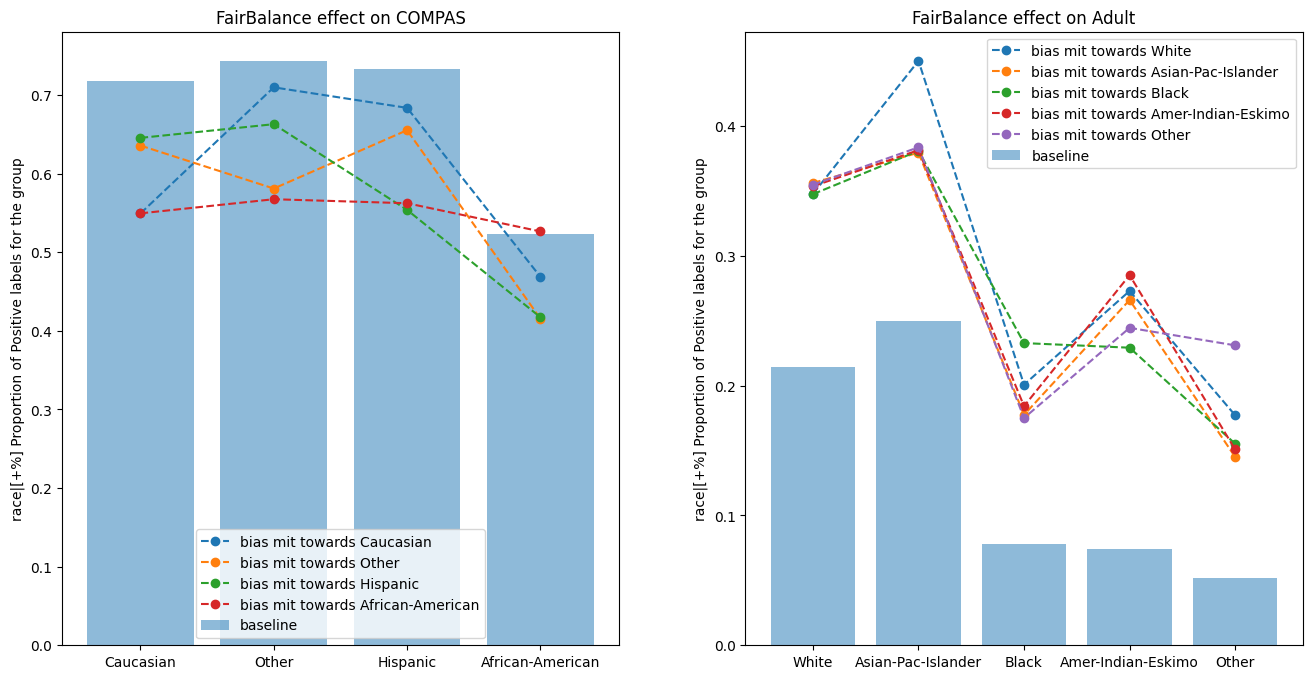

In [ ]:
# proportion of positive lables for each race
reps = 20
metric = 'race|'+Metrics.POS
run_experiment_group(reps, metric, attrs= ["race"])
# same but bias mitigated for sex and race
run_experiment_group(reps, metric)


 new tester ---------------------------------
--------------
--------------
--------------
--------------
--------------

 new tester ---------------------------------
--------------
--------------
--------------
--------------
--------------

 new tester ---------------------------------
--------------
--------------
--------------
--------------
--------------
--------------

 new tester ---------------------------------
--------------
--------------
--------------
--------------
--------------
--------------


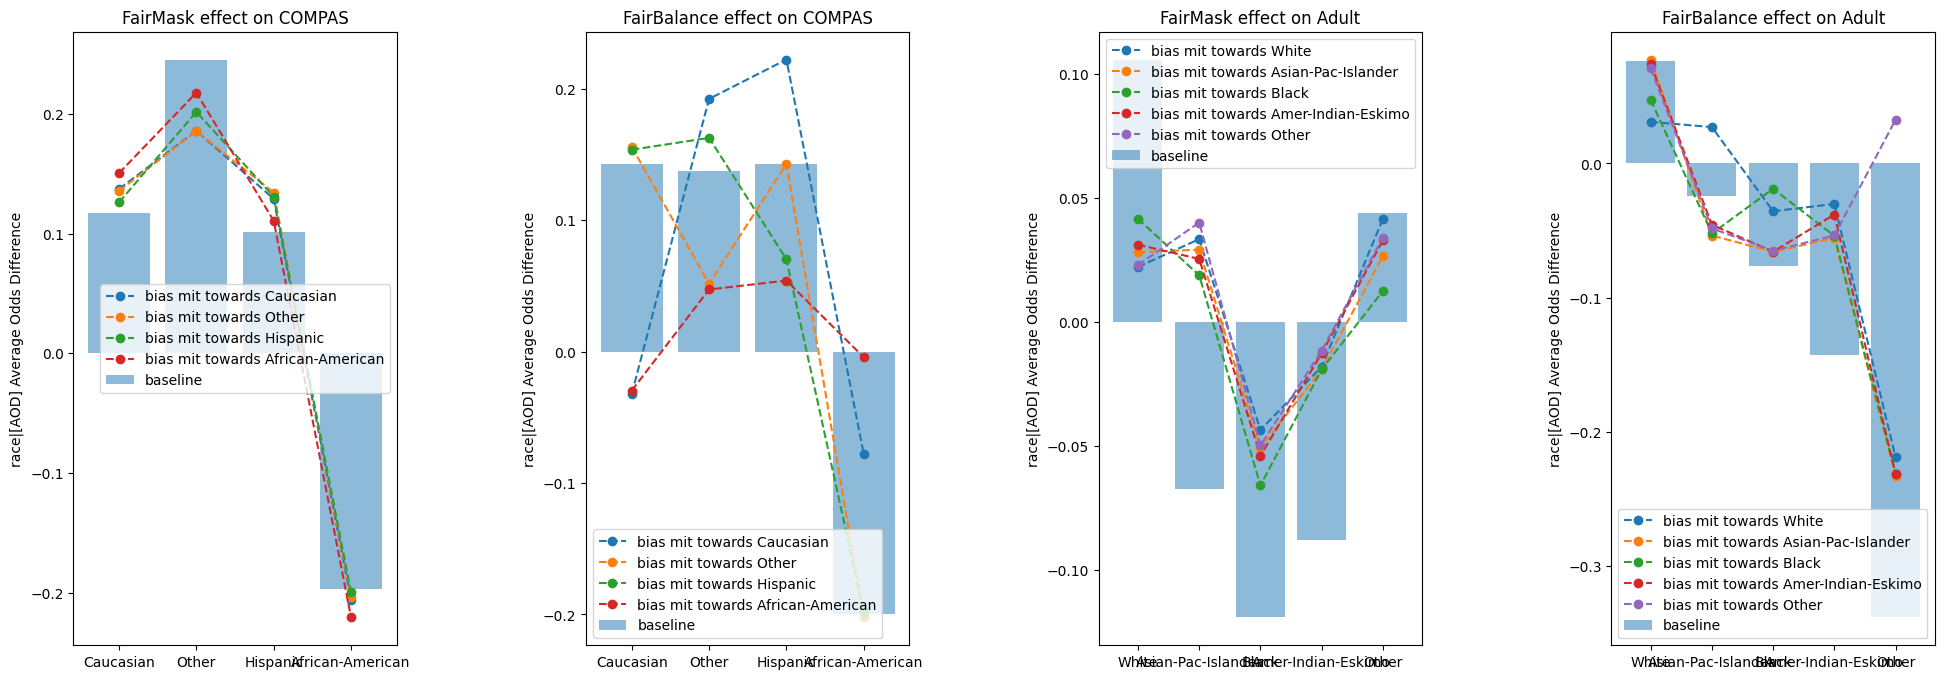

In [ ]:
reps = 10
metric =  Metrics.M_AOD
run_experiment_group(reps, metric, attrs=["race"])
# same but bias mitigated for sex and race
run_experiment_group(reps, metric)


 new tester ---------------------------------
--------------
--------------
--------------
--------------
--------------

 new tester ---------------------------------
--------------
--------------
--------------
--------------
--------------

 new tester ---------------------------------
--------------
--------------
--------------
--------------
--------------
--------------

 new tester ---------------------------------
--------------
--------------
--------------
--------------
--------------


KeyboardInterrupt: 

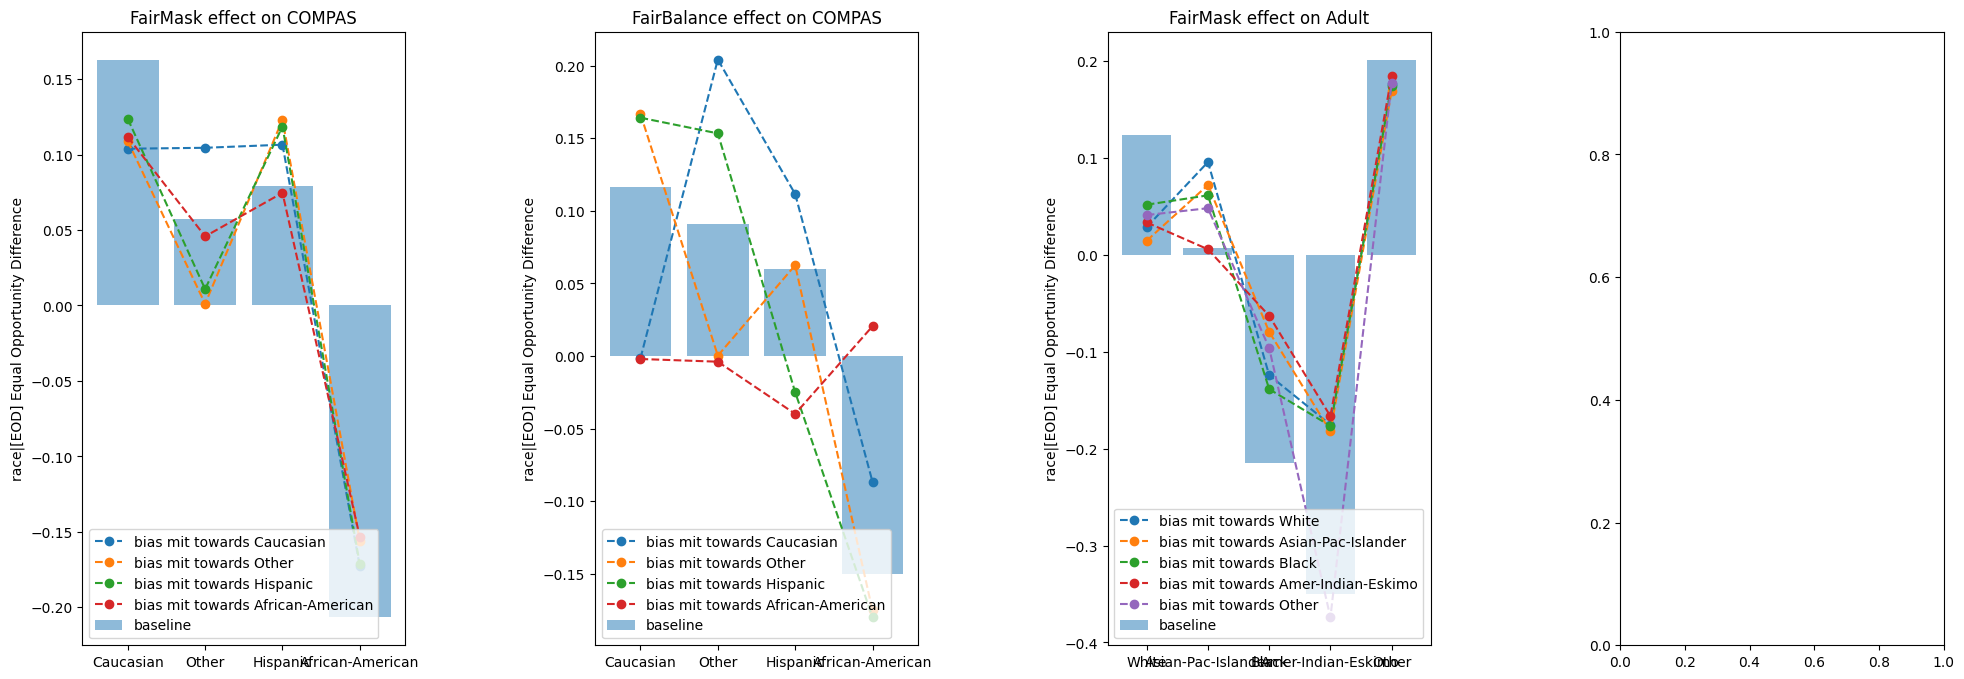

In [ ]:
reps = 1
metric =  'race|'+Metrics.EOD
run_experiment_group(reps, metric)

In [ ]:
reps = 1
metric =  'race|'+Metrics.DI
run_experiment_group(reps, metric)

In [ ]:
reps = 1
metric =  'race|'+Metrics.SPD
run_experiment_group(reps, metric)

In [ ]:
"""
OBSERVATIONS:

Fairmask does not do much on Compas (presumanbly cause data is so biased)
And does maybe a bit on Adult

Fairbalance just basically tweeks the treshold of positive vs negative outcomes. But just as before groups are discriminated at similar proportions


A different ML method does not really do much to change this as the logib behind this remains the same.
Mayhaps it changes how much the undersampled grops are discriminated against but thats it. 

In every single one of the cases there are subgroups for whom discrimination is iincreased in every example!

TODO:
see what if we ignore gender vs dont
combine some tiny groups into Other
what metric works the best on disproportionate groups
report variance.

"""
pass

## RUNNING EXPERIMENTS WITH FEWER RACES

In [ ]:
mls = { # bias mitigation method, ML algo, secondary ML alg, preprocessing, other
    "FB Baseline":(Tester.BASE_ML,      Model.LG_R, None, "FairBalance merge races", other_fb), 
    "FairBalance":(Tester.FAIRBALANCE,  Model.LG_R, None, "FairBalance merge races", other_fb), 

    "FM Baseline":(Tester.BASE_ML,      Model.RF_C, None,       "FairMask merge races",    other), 
    "FairMask":   (Tester.FAIRMASK,     Model.RF_C, Model.DT_R, "FairMask merge races",    other)
}

after
{'Other', 'Caucasian', 'African-American'}
African-American    3684
Caucasian           2445
Other               1056
Name: race, dtype: int64
after
{'Asian-Pac-Islander', 'Other', 'White', 'Black'}
White                 27816
Black                  3124
Asian-Pac-Islander     1039
Other                   582
Name: race, dtype: int64


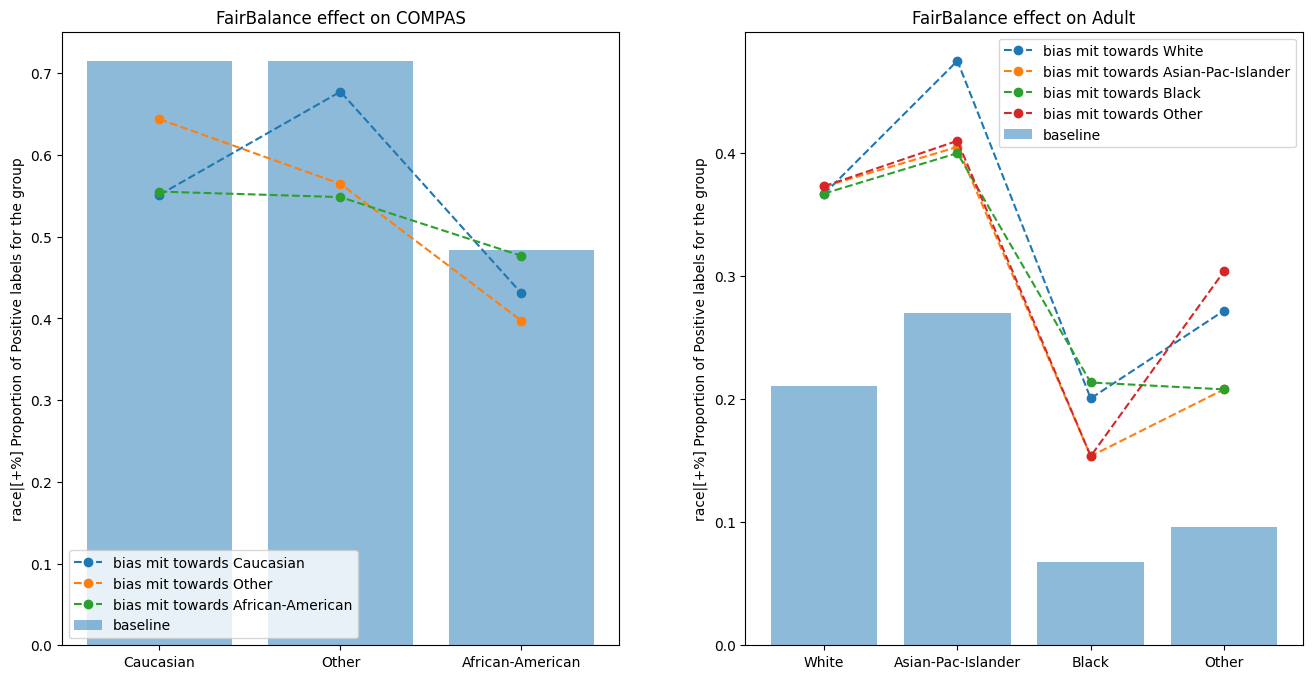

In [ ]:
# proportion of positive lables for each race for one run
reps = 20
metric = 'race|'+Metrics.POS
run_fb_experiment_group(reps, metric, mls, ["race"])
# same but bias mitigated for sex and race
run_experiment_group(reps, metric, mls)

In [ ]:
# Change in bias scale. (change in the absolute value of spd) 
reps = 20
metric =  'race|'+Metrics.SPD
run_change_fb_experiment_group(reps, metric, mls, ["race"])
# same but bias mitigated for sex and race
run_change_experiment_group(reps, metric, mls)